In [1]:
import numpy as np
import numba
from numba import cuda
import math
import time
import cv2
from google.colab.patches import cv2_imshow

In [2]:
# Функция создания шума
def noise_generator(img, p):
  rnd = np.random.rand(img.shape[0], img.shape[1])
  img[rnd < p] = 0
  img[rnd > 1 - p] = 255
  return img

In [3]:
def salt_and_pepper_cpu(input_img):
  output_img = np.zeros(input_img.shape)
  for i in range(input_img.shape[0] - 1):
    for j in range(input_img.shape[1] - 1):
      t = np.zeros(9)
      for idx in range(9):
        t[idx] = input_img[idx//3 - 1 + i][idx % 3 - 1 + j]
      for k in range(8):
        for l in range(8-k):
          if t[l] > t[l + 1]:
            t[l], t[l + 1] = t[l + 1], t[l]
      output_img[i][j] = np.median(t)
  return output_img

In [4]:
# CUDA ядро
@cuda.jit
def salt_and_pepper_kern(img, res_img):
  i, j = cuda.grid(2)
  t = cuda.local.array(shape=9, dtype=numba.int64)

  for idx in range(9):
    t[idx] = img[idx//3 - 1 + i][idx % 3 - 1 + j]

  for k in range(8):
    for l in range(8-k):
      if t[l] > t[l+1]:
        t[l], t[l+1] = t[l+1], t[l]
  res_img[i][j] = t[4]


# GPU фильтр
def salt_and_pepper_gpu(h_input_img):
  block_size = (32, 32)
  grid_size=(math.ceil(h_input_img.shape[0]/block_size[0]), math.ceil(h_input_img.shape[1]/block_size[1]))

  start = cuda.event()
  end = cuda.event()

  start.record()

  d_input_img = cuda.to_device(h_input_img)
  d_output_img = cuda.to_device(np.zeros(h_input_img.shape))
  salt_and_pepper_kern[grid_size, block_size](d_input_img, d_output_img)

  end.record()
  end.synchronize()

  elapsed_time = cuda.event_elapsed_time(start, end)
  return d_output_img.copy_to_host(), elapsed_time / 1000

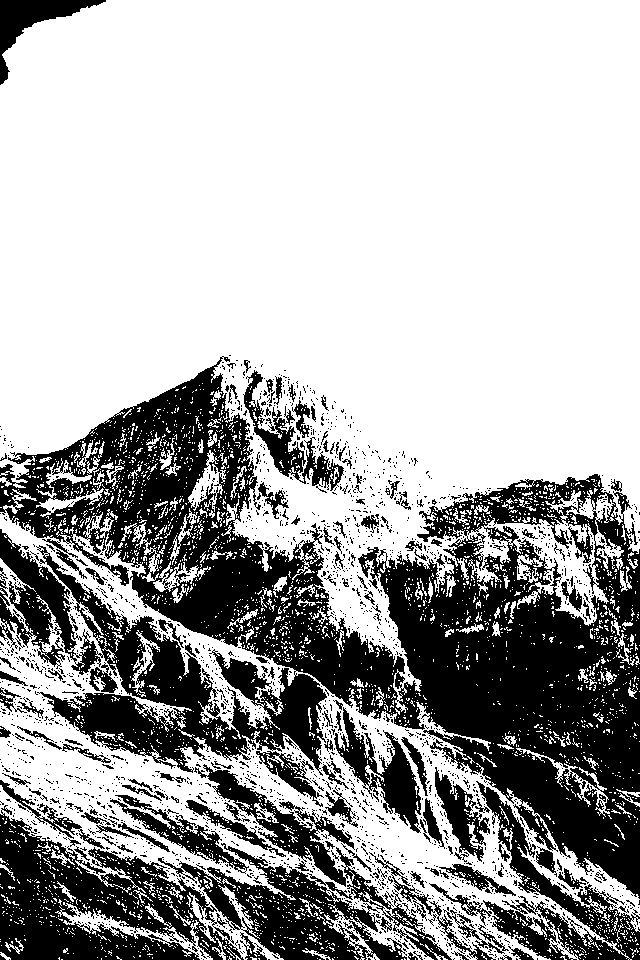

In [5]:
# Загрузка bmp картинки с гугл диска
image = cv2.imread('/content/drive/MyDrive/image.bmp', cv2.IMREAD_GRAYSCALE)
cv2_imshow(image)

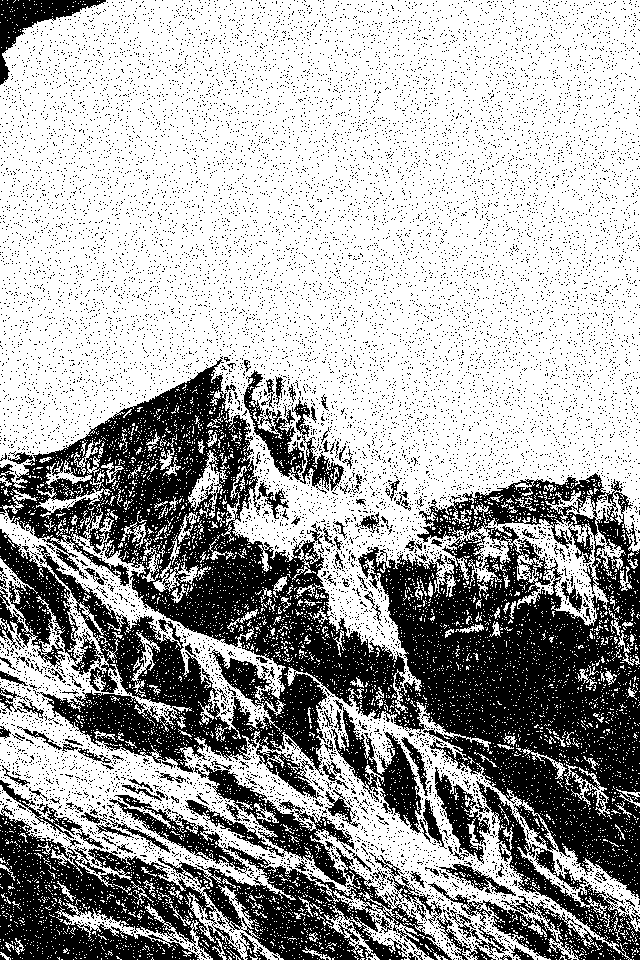

In [6]:
# Создаем "шумную" картинку, второй параметр в функции ниже определяет как сильно будет зашумлена картинка
noisy_image = noise_generator(image, 0.045)
cv2_imshow(noisy_image)

Время выполнения GPU: 1.014946533203125


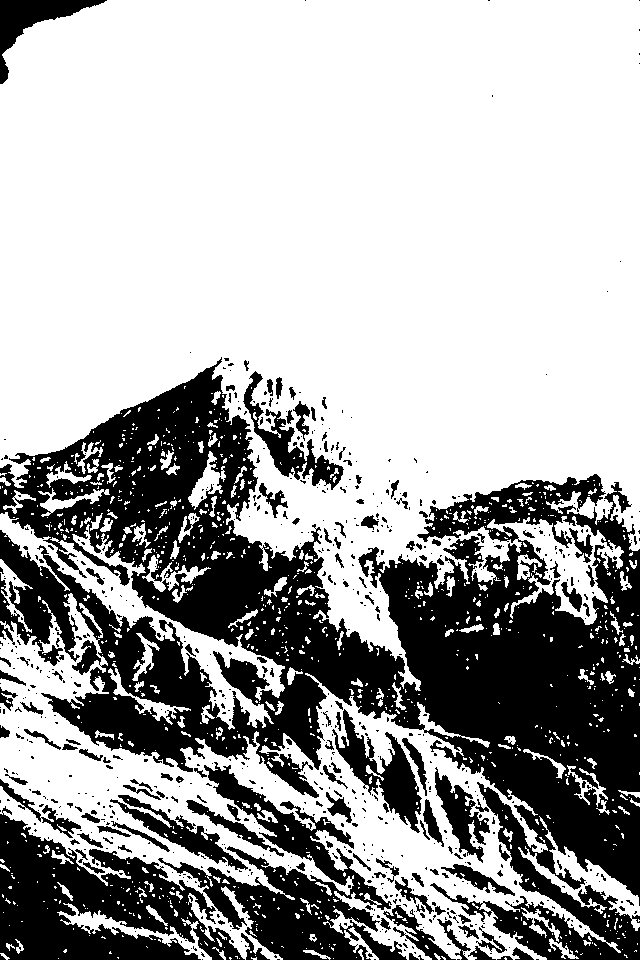

In [7]:
result_gpu, time_gpu = salt_and_pepper_gpu(noisy_image)
print(f"Время выполнения GPU: {time_gpu}")
cv2_imshow(result_gpu)

Время выполнения CPU: 29.225335359573364


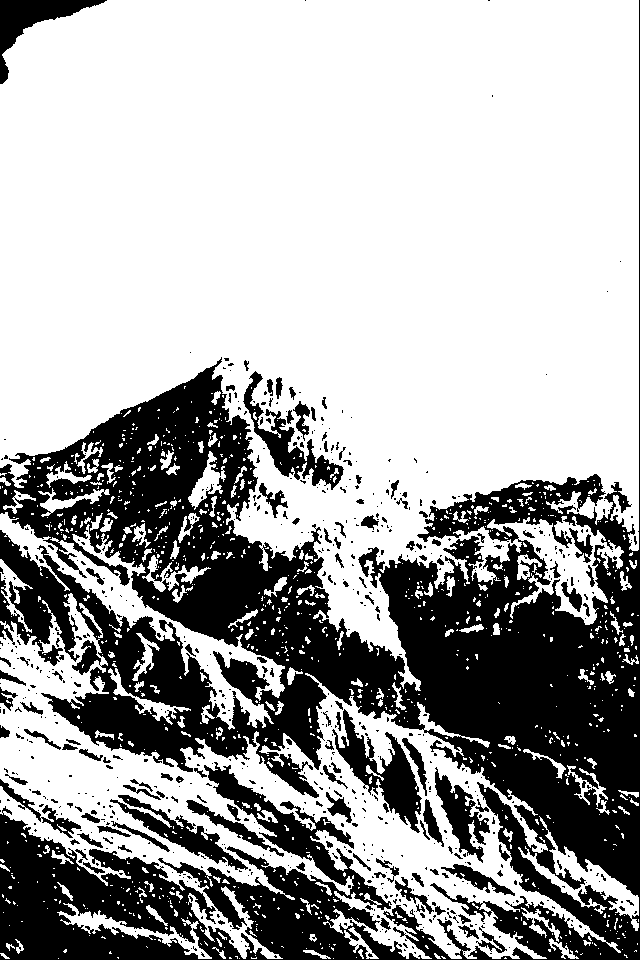

In [8]:
start = time.time()
result_cpu = salt_and_pepper_cpu(noisy_image)
cpu_time = time.time() - start
print(f"Время выполнения CPU: {cpu_time}")
cv2_imshow(result_cpu)

In [10]:
print(f"Ускорение: {cpu_time/time_gpu}")

Ускорение: 28.79495067325324
